In [51]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam

import tensorflow as tf
import datetime


Using TensorFlow backend.


In [115]:
def sigmoid(x,c=0,w=1):
    return 1.0/(1.0+np.exp(-(x-c)/w))

def d1_sigmoid(x,c=0,w=1):
    return (1.0/w)*sigmoid(x,c,w)*(1.0-sigmoid(x,c,w))

class Change1(gym.Env):
    """Model Change environment
    This game presents moves along a linear chain of states, 
    where each action is the number of states to take (from 1 to 10),
    which moves along the chain.  The state will be returned as both the 
    current integer-index, and the value of a scaler from 0 to 1.  This
    scaler will vary according to a sigmoid function, defined at the time of 
    enviornment instantiation (define width and center position).
    
    The reward from each point will be the derivative of this sigmoid function,
    offset and rescaled by certain criteria passed to the env at creation.
    
    The goal is thus to take large jumps along the path when nothing is changing,
    and small steps when changing dramatically.  The game completes when a move 
    takes the state beyond end endpoint.

    The observed state is the current state in the chain (0 to n-1) and value of scaler.
    """    
    def __init__(self, L=500, cmin=50, cmax=450, wmin=1, wmax=10, sinkscore = 0.2, power=.50, lookback=10,
                c = None, w = None):
        self.cmin = cmin
        self.cmax = cmax
        self.wmin = wmin
        self.wmax = wmax
        self.L = L
        self.power = power
        self.sinkscore = sinkscore #fraction to drop score floor
        self.lookback = lookback #how many previous entries to remember
        
        if c == None:
            self.c = np.random.random()*(self.cmax-self.cmin)+self.cmin
        else:
            self.c = c
        if w == None:
            self.w = np.random.random()*(self.wmax-self.wmin)+self.wmin
        else:
            self.w = w

        
        self.action_space = spaces.Discrete(10) #assume we can take steps 1 to 10
                
        #setup observation_space
        high = np.array((self.lookback+1)*[
            int(self.L),
            np.finfo(np.float32).max])
        low = np.array((self.lookback+1)*[
            int(0),
            -1.0*np.finfo(np.float32).max])
            
        self.observation_space = spaces.Box(low, high, dtype=np.float32)
        ##############

        self.seed()
        #self.reset()
        
        #state needs to begin with a bunch of nothing
        self.state = np.array((self.lookback+1)*[0.0, 0.0])
        self.state[0] = 0
        self.state[1] = self.value_map_func(0) #first value

        #####################
        #fill out first N=lookback spaces by taking single-steps
        for _ in range(self.lookback):
            self.step(0)

    def value_map_func(self,x):
        return sigmoid(x,c=self.c, w=self.w)

    def score_map_func(self,x):
        return d1_sigmoid(x,c=self.c,w=self.w)**self.power-self.sinkscore

    def report(self):
        print ("at site "+str((int(self.state[0]))) +" with value "+str(self.state[1]))
        print ("back\tvalue")
        for i in np.arange(2,2*self.lookback+1,2):
            print (str(int(self.state[i]))+'\t'+str(self.state[i+1]))

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self,action):
        assert self.action_space.contains(action)
        newstate = np.roll(self.state,2)
        newstate[2] = 0
        newstate[0] = 0
        
        for i in np.arange(2,int(self.lookback*2+1),2):
            newstate[i] = newstate[i]+(action+1)
            
        newstate[0] = int(self.state[0])+(action+1)
        
        
        if newstate[0] >= self.L:
            done = True
            newstate[0] = self.L-1
        else:
            done = False
            
        newstate[1] = self.value_map_func(newstate[0])
        self.state = newstate
        
        reward = self.score_map_func(self.state[0])
        
        return self.state, reward, done, {}

    def reset(self):
        self.c = np.random.random()*(self.cmax-self.cmin)+self.cmin
        self.w = np.random.random()*(self.wmax-self.wmin)+self.wmin
        
        #state needs to begin with a bunch of nothing
        self.state = np.array((self.lookback+1)*[0.0, 0.0])
        self.state[0] = 0
        self.state[1] = self.value_map_func(self.state[0]) #first value
        
        #fill out first N=lookback spaces by taking single-steps
        for _ in range(self.lookback):
            self.step(0)
        
        return self.state


In [116]:
env = Change1(lookback=10,power=.50, cmin=50, cmax=450, wmin = 1, wmax=10,sinkscore=.02,c=5)

In [117]:
env.c

5

In [46]:
env.wmax=10

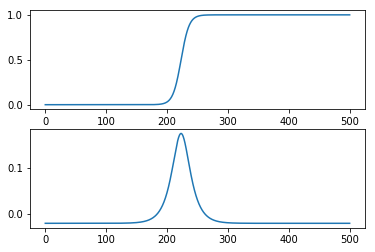

In [50]:
plt.figure()
env.reset()
x = np.linspace(0,env.L,1001)
plt.subplot(211)
plt.plot(x,env.value_map_func(x))
plt.subplot(212)
plt.plot(x,env.score_map_func(x))

Now for the learner.

In [53]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size #maximum size
        self.mem_cntr = 0 #counter of how far we've used the memory
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape)) #make with shape of enviornment
        self.new_state_memory = np.zeros((self.mem_size, input_shape)) #capture new state (same shape as old state)
        dtype = np.int8 if self.discrete else np.float32 # when actions are discrete, use int
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype = dtype)
        self.reward_memory = np.zeros(self.mem_size) # for the reward
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32) #sampling from many episodes, when episode is over, don't want to sample next state


    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size #find address of first availble memory, overwrite earliest memories
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        if self.discrete: #store one-hot memory
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1-int(done)
        self.mem_cntr += 1

    def sample_buffer(self, batch_size): #allow agent to sample non-sequential memories
        max_mem = min(self.mem_cntr, self.mem_size) #use current size of memory, or memory size (whatever smaller)
        batch = np.random.choice(max_mem, batch_size) #create a random selection of the desired size
        states = self.state_memory[batch]
        new_state = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, new_state, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    """ take learning rate, number of actions, input dimensions, and dimensions of 1st and 2nd fully connected layers """
    model = Sequential([
        Dense(fc1_dims, input_shape=(input_dims,)),
        Activation('relu'),
        Dense(fc2_dims, input_shape=(input_dims,)),
        Activation('relu'),
        Dense(n_actions)
    ])

    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

class DDQNAction(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
        input_dims, epsilon_dec = 0.996, epsilon_end = 0.01, 
        mem_size = 100000, fname = 'ddqn_model.h5', replace_target = 100):
        # alpha, gamma = discount rate for future states, 
        # DDQN = two networks = one to choose action,
        # second to decide value of that action.  We 
        # eplace weights of second network every replace_target games

        self.n_actions = n_actions
        self.action_space = [i for i in range(self.n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_name = fname
        self.replace_target = replace_target
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions, True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)
        self.q_target = build_dqn(alpha, n_actions, input_dims, 256, 256)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size: # don't bother until your batch size is met
            state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)
            action_values = np.array(self.action_space, dtype = np.int8)
            action_indicies = np.dot(action, action_values)

            q_next = self.q_target.predict(new_state)
            q_eval = self.q_eval.predict(new_state)

            q_pred = self.q_eval.predict(state)

            max_action = np.argmax(q_eval, axis=1)

            q_target = q_pred # we have to pass in states to fit functions, use mse loss, find delta between target values and q-predicted network
            #want differences for off-action columns to be zero, only want diff to zero for action agent took\
            
            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indicies] = reward + self.gamma*q_next[batch_index, max_action.astype(int)]*done

            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.epsilon = self.epsilon * self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon_min

            if self.memory.mem_cntr % self.replace_target == 0:
                self.update_network_parameters()

    def update_network_parameters(self):
        self.q_target.model.set_weights(self.q_eval.model.get_weights())

    def save_model(self,use_name = None):
        if use_name == None:
            self.q_eval.save(self.model_name)
        else:
            self.q_eval.save(use_name)

    def load_model(self):
        self.q_eval = load_model(self.model_name)

        if self.epsilon == self.epsilon_min:
            self.update_network_parameters()


In [64]:
ddqn_agent.epsilon

0.01

In [74]:
%matplotlib inline

In [234]:
def test_gambit(model, clist, wlist, L=500, sinkscore = 0.2, power=0.5,chatty=False):
    """ Runs model through set of fixed tests, defined as sigmoids with centers in clist, 
    and widths in wlist.  Assumes len(clist) == len(wlist)."""
    play_score_list = np.zeros(len(clist))
    max_score_list = np.zeros(len(clist))
    allpt_score_list = np.zeros(len(clist))
    bigstep_score_list = np.zeros(len(clist))
    
    x = np.arange(0,L,1)
    big_x = np.arange(0,L,10)
    
    for i in range(len(clist)):
        this_c = clist[i]
        this_w = wlist[i]
        this_env = Change1(c = this_c, w=this_w, sinkscore=sinkscore, power=power)
        
        #find sum of all points in this game
        allpt_score_list[i] = np.sum(this_env.score_map_func(x))
        
        #find sum of all positive points in this game
        max_score_list[i] = np.sum(this_env.score_map_func(x)[this_env.score_map_func(x)>0])
        
        #assume just step across as fast as possible
        bigstep_score_list[i] = np.sum(this_env.score_map_func(big_x))
        
        #now using the AI
        done = False
        move_list = []
        spot_list = []
        reward_list = []
        start_spot = this_env.state[0]

        while not done:
            input_data = (this_env.state).reshape(1,int(model.input_shape[1]))
            predicted_output = model.predict(input_data)
            predicted_best_action = np.argmax(predicted_output)
            #move_list.append(predicted_best_action)
            #spot_list.append(this_env.state[0])
            #reward_list.append(score_map[int(spot_list[-1])])
            new_state, reward, done, _ = this_env.step(predicted_best_action)    
            play_score_list[i] += reward
    if chatty:
        print ('Best scores possible: \t'+str(max_score_list)+' \tsum '+str(sum(max_score_list)))
        print ('Every-point scores: \t'+str(allpt_score_list)+' \tsum '+str(sum(allpt_score_list)))
        print ('Big-stepping scores: \t'+str(bigstep_score_list)+' \tsum '+str(sum(bigstep_score_list)))
        print ('AI scores: \t\t'+str(play_score_list)+ '\tsum '+str(sum(play_score_list)))
    
        print ('AI-score over best-score '+str(play_score_list/max_score_list))
        print ('AI-score over best-score '+str(play_score_list/max_score_list))
        return None
    return sum(play_score_list)

In [211]:
test_gambit(ddqn_agent.q_eval,[20,40,60,80],[1,3,5,7],L=100,sinkscore=.02)

11.24396391248333

In [250]:
test_gambit(load_model('best_avgscore_dqn.h5'),gambit_clist, gambit_wlist,L=env.L,sinkscore=env.sinkscore,chatty=True)

Best scores possible: 	[1.82577142 2.06475467 1.60880265 1.82577142 2.06475467 1.60880265
 1.82577142 2.06475467 1.60880265 1.82577142 2.06475467 1.60880265
 1.82577142 2.06475467 1.60880265] 	sum 27.496643730092366
Every-point scores: 	[-26.85840734 -22.97537837 -20.57810721 -26.85840734 -23.00684951
 -20.93757928 -26.85840734 -22.97518801 -20.59915492 -26.85840734
 -23.0038364  -20.59787129 -26.85840734 -22.97539863 -20.95822467] 	sum -352.8996249674264
Big-stepping scores: 	[-2.4864333  -2.297385   -2.05781796 -2.4864333  -2.30214001 -2.085402
 -2.4864333  -2.29737348 -2.06055204 -2.4864333  -2.29912685 -2.0592684
 -2.4864333  -2.2974053  -2.10604738] 	sum -34.29468493208462
AI scores: 		[ -8.6109933   -6.0468869   -7.52480022 -11.32569116 -11.08209126
  -6.38632834  -8.36042925  -8.26913872  -9.18118019 -11.87877226
  -6.66112718  -6.0268399   -9.71664252 -10.01622469 -10.40476178]	sum -131.49190765478028
AI-score over best-score [-4.7163589  -2.92862246 -4.67726741 -6.20323608 -5.

In [251]:
if __name__ == '__main__':
    #generate enviornment
    load_previous_model = False
    
    gambit_clist = 3*[50, 100, 150, 200, 250]
    gambit_wlist = 5*[1,5,9]
    
    env = Change1(lookback=10,power=.250, cmin=20, cmax=280, wmin = 1, wmax=10,sinkscore=.1,L=300)

    ddqn_agent = DDQNAction(alpha = 0.0005, gamma = 0.99, n_actions = 10, epsilon = 1.0,
                    batch_size = 64, input_dims=22)
    
    if load_previous_model:
        ddqn_agent.load_model() # if load a saved model
        ddqn_agent.epsilon = 0.01
    
    n_games = 1000
    ddqn_scores = []
    eps_history = []
    reward_history = []
    action_history = []
    avg_gscore_history = []
    single_gscore_history = []

    best_avg_score = -99999.0
    best_single_score = -99999.0

    for i in range(n_games):
        done = False
        score = 0
        action_counter = []
        reward_counter = []
        observation = env.reset()
        while not done:
            action = ddqn_agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            action_counter.append(action)
            reward_counter.append(reward)
            ddqn_agent.remember(observation, action, reward, observation_, done)
            observation = observation_
            ddqn_agent.learn()

        eps_history.append(ddqn_agent.epsilon)
        ddqn_scores.append(score)

        avg_score = np.mean(ddqn_scores[max(0, i-100):(i+1)])
        if avg_score > best_avg_score and i > 100:
            #print ("new avg highscore!")
            ddqn_agent.save_model('best_avgscore_dqn.h5')
            best_avg_score = avg_score

        if score > best_single_score and i > 10:
            #print ("new single highscore!")
            ddqn_agent.save_model('best_singlescore_dqn.h5')
            best_single_score = score

        #print to screen stats
        #if i % 20 == 0:
        #    print ('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score)
        
        if i % 50 == 0:
            print ('\nepisode '+str(i))
            single_gscore = test_gambit(load_model('best_singlescore_dqn.h5'),gambit_clist,gambit_wlist,
                                        L=env.L,sinkscore=env.sinkscore,power=env.power)
            print ("gambit best-single score "+str(single_gscore))
            single_gscore_history.append(single_gscore)
            
            avg_gscore = test_gambit(load_model('best_avgscore_dqn.h5'),gambit_clist,gambit_wlist,
                                     L=env.L,sinkscore=env.sinkscore,power=env.power)
            print ("gambit best-avg score "+str(avg_gscore))
            avg_gscore_history.append(avg_gscore)
            
        #periodically save agent
        if i % 10 == 0 and i > 0:
            ddqn_agent.save_model()


episode 0
gambit best-single score -42.89056302768646
gambit best-avg score -26.087221277294987


C:\Users\dolds\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '



episode 50
gambit best-single score -335.8974953819852
gambit best-avg score -26.087221277294987

episode 100
gambit best-single score -165.7626723581883
gambit best-avg score -26.087221277294987

episode 150
gambit best-single score -72.4675774942692
gambit best-avg score -83.5424403429255

episode 200
gambit best-single score -187.83288257921802
gambit best-avg score -213.6395610758413

episode 250
gambit best-single score -187.83288257921802
gambit best-avg score -107.96297089022855

episode 300
gambit best-single score -187.83288257921802
gambit best-avg score -77.68779096618248

episode 350
gambit best-single score -187.83288257921802
gambit best-avg score 12.092052220466151

episode 400
gambit best-single score -187.83288257921802
gambit best-avg score 11.391297231712064


KeyboardInterrupt: 

In [235]:
test_gambit(load_model('best_avgscore_dqn.h5'),[20,40,60,80],[1,3,5,7],L=env.L,sinkscore=env.sinkscore,chatty=True)

Best scores possible: 	[2.74851032 4.39434671 5.38192678 5.53121982] 	sum 18.056003642275464
Every-point scores: 	[1.14152268 3.437176   4.92821129 5.0071096 ] 	sum 14.514019566815126
Big-stepping scores: 	[0.31356639 0.34978624 0.48902659 0.45815002] 	sum 1.6105292455122358
AI scores: 		[0.12685744 1.75675043 3.19736198 3.96907423]	sum 9.050044084900257
AI-score over best-score [0.04615498 0.39977511 0.59409243 0.71757666]
AI-score over best-score [0.04615498 0.39977511 0.59409243 0.71757666]


In [228]:
%matplotlib notebook

<IPython.core.display.Javascript object>


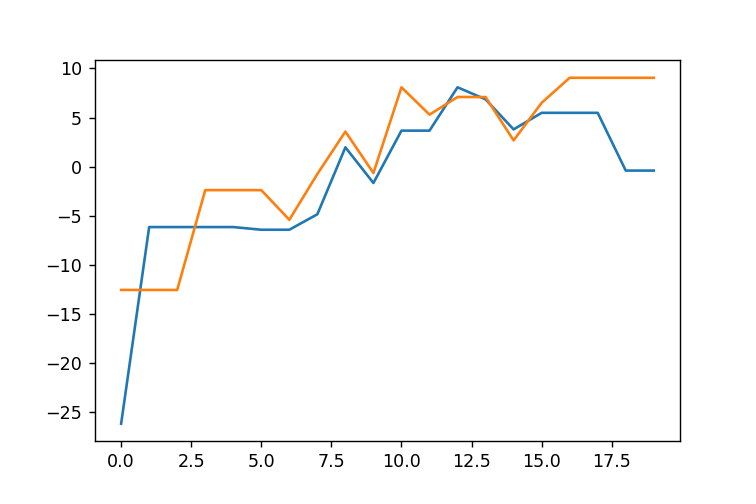

In [231]:
plt.figure()
plt.plot(single_gscore_history)
plt.plot(avg_gscore_history)

In [230]:
plt.figure()
plt.plot(ddqn_scores)

In [203]:
trained_network = load_model('best_singlescore_dqn.h5')

<IPython.core.display.Javascript object>


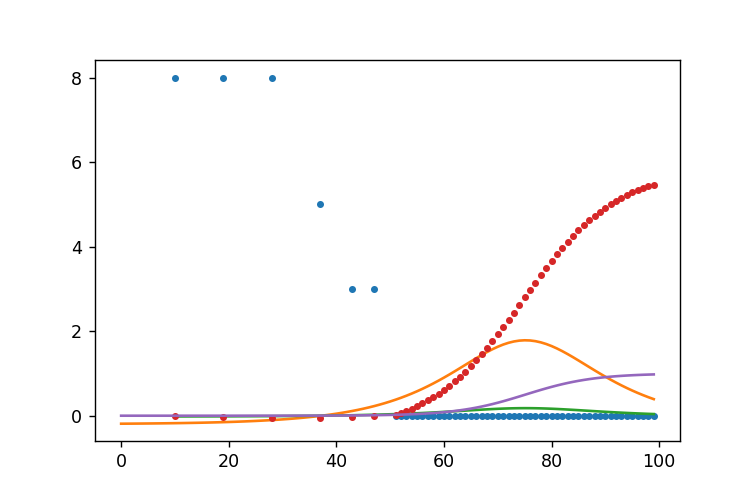

final score 5.472218933480015


In [236]:
env.reset()

done = False
move_list = []
spot_list = []
reward_list = []
start_spot = env.state[0]

#trained_network = load_model('ddqn_model.h5')
x = np.arange(0,env.L,1,dtype=float)
score_map = env.score_map_func(x)
value_map = env.value_map_func(x)
while not done:
    input_data = (env.state).reshape(1,int(trained_network.input_shape[1]))
    predicted_output = trained_network.predict(input_data)
    predicted_best_action = np.argmax(predicted_output)
    move_list.append(predicted_best_action)
    spot_list.append(env.state[0])
    reward_list.append(score_map[int(spot_list[-1])])
    new_state, reward, done, _ = env.step(predicted_best_action)

plt.figure()
plt.plot(spot_list, move_list,'.')
plt.plot(score_map*10)
plt.plot(spot_list,reward_list)
plt.plot(spot_list,np.cumsum(reward_list),'.')
plt.plot(value_map*1 )
print ('final score '+str(sum(reward_list)))

In [179]:
ddqn_agent.model_name

'ddqn_model.h5'

In [180]:
trained_network

In [183]:
ddqn_agent.q_eval

<IPython.core.display.Javascript object>


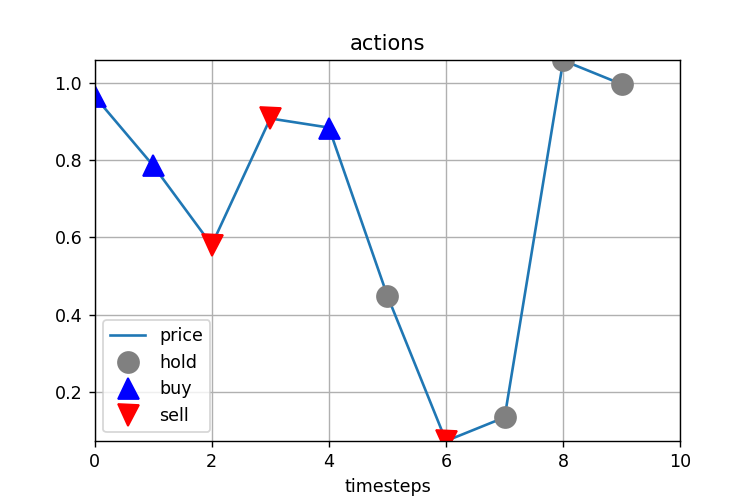

In [237]:
class LivePlotNotebook(object):
    """
    Live plot using %matplotlib notebook in jupyter notebook
    
    Usage:
    ```
    import time
    liveplot = LivePlotNotebook()
    x=np.random.random((10,))
    for i in range(10):
        time.sleep(1)
        liveplot.update(
            x=x+np.random.random(x.shape)/10,
            actions=np.random.randint(0, 3, size=(10,))
        )
    ```
    
    url:
    """

    def __init__(self):
        %matplotlib notebook
        fig,ax = plt.subplots(1,1)
        
        ax.plot([0]*20, label='price')
        ax.plot([1]*20, [1]*20, 'o', ms=12,c='gray', label='hold')
        ax.plot([0]*20, [0]*20, '^', ms=12,c='blue', label='buy' )
        ax.plot([0]*20, [0]*20, 'v', ms=12,c='red', label='sell')
        
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.legend()
        ax.set_xlabel('timesteps')
        ax.grid()
        ax.set_title('actions')
        
        self.ax = ax
        self.fig = fig

    def update(self, x, actions):             
        # update price
        line = self.ax.lines[0]
        line.set_xdata(range(len(x)))
        line.set_ydata(x)
        
        # update action plots
        for i, line in enumerate(self.ax.lines[1:]):
            line.set_xdata(np.argwhere(actions==i).T)
            line.set_ydata(x[actions==i])
            line.set_marker(['o','^','v'][i])

        # update limits
        self.ax.set_xlim(0, len(actions))
        self.ax.set_ylim(x.min(), x.max())

        self.fig.canvas.draw()
        
# Test
import time
liveplot = LivePlotNotebook()
x=np.random.random((10,))
for i in range(10):
    time.sleep(1)
    liveplot.update(
        x=x+np.random.random(x.shape)/10,
        actions=np.random.randint(0, 3, size=(10,))
    )